## **A**utomated **L**earning for **I**nsightful **C**omparison and **E**valuation - (ALICE)

The framework allows for combining backwards feature elimination with inter-rater reliability for both classification and regression tasks on cross-sectional data.

### Table of Contents
1) General Imports<br>
2) Introduction to $\texttt{aliceHU}$<br>
3) Data Preparation<br>
    3.1) Dummy-Grouping for $\texttt{BackEliminator}$<br>
    3.2) Data Scaling<br>
4) Compiling Models for $\texttt{BackEliminator}$<br>
5) Experiments<br>
5.1) Logistic Regression and MultiLayer Perceptron<br>
5.2) Random Forest and MultiLayer Perceptron<br>
5.3) Random Forest and Logistic Regression<br>
6) Cross Comparisons<br>

# 1) General Imports 

Below are some imports that will be used throghout the notebook

In [ ]:
# Import numpy for mathematical operations
import numpy as np
# Import pandas for handling data tables
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Import stats from scipy - the key statistical package (an extension of Numpy) for python
from scipy import stats

# import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

# This just saves the directory
import os
cur_dir = os.getcwd()
import pickle

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import tensorflow as tf


# 2) Introduction to $\texttt{aliceHU}$

The framework is designed so that it can just be imported as an entire module if needed.
But for demonstration we can use separate parts instead.

In [3]:
# Can just import entire module
import alice

The main object in the framework is $\texttt{BackEliminator}$, which carries out
the feature selection - agreeability algorithm.

The source code is given in `alice/search_and_compare/sequential.py`.
Below it can be imported and its documentation inspected.

In [5]:
# Import
from alice.search_and_compare.sequential import BackEliminator

In [6]:
# Look at documentation
BackEliminator?

Init signature:
BackEliminator(
    X=None,
    y=None,
    validation_data=None,
    task_type=None,
    criterion=None,
    agreeability=None,
    dummy_list=None,
    features_to_fix=None,
)
Docstring:     
The class is built for conducting backwards feature elimination in
combination with model agreeability.

Args:
    X (pd.DataFrame): A pandas dataframe containing predictors.
    y (pd.DataFrame): A pandas dataframe containing target.
    validation_data (tuple): A tuple of validation data
                             (X_val, y_val).
    task_type (str): String for task type. Available options -
                     'classification' or 'regression'.
    criterion (str): String for intra-model evaluation criterion.
                     Available options: ('mse', 'rmse', 'mae',
                                        'accuracy', 'precision',
                                        'recall', 'f1')
    agreeability (str): String for inter-model comparison.
                        Ava

The key methods of the $\texttt{BackEliminator}$ will be demonstrated in the experiments section.

The methods are:
- `.compare_models()` --- to run the algorithm on two different models and obtain *between* results.
- `.dataframe_from_results()` --- to generate da pandas DataFrame from the results
- `.plot_best()` --- to generate a plot of best model scores per feature elimination iteration and their agreeability.
- `.plot_all()` --- to generate a plot of mean model scores per feature elimination iteration and their mean agreeability.
- `.interactive_plot()` --- to generate an interactive plot of the results.
- `.compare_n_best()` --- to test the differences between predictions *within* models.

Besides, these, individual functions that are used in the framework can be imported separately:

In [4]:

# Import regression metrics
from alice.metrics.regress import mse, rmse, mae
# Import classification metrics
from alice.metrics.classify import accuracy, precision, recall, f1

# Import regression agreeability metric
from alice.agreeability.regress import pearson
# Import classification agreeability metric
from alice.agreeability.classify import cohen_kappa

# Import regression tests
from alice.testing.regress import t_test
# Import classification tests
from alice.testing.classify import mcnemar_binomial, mcnemar_chisquare

# 3) Data Preparation

Below I import the pickled training and test sets for the experiments on the Telekom customer churn classification. 

For in depth look at data pre-processing steps refer to `customer_churn_dataprocessing.ipynb`

In [7]:
## Set up paths
raw_train_path = 'clean_data/class_telco/raw_train.pkl'
upsampled_train_path = 'clean_data/class_telco/upsampled_train.pkl'
test_path = 'clean_data/class_telco/test.pkl'


In [8]:
# Load upsampled train set
with open(upsampled_train_path, 'rb') as f:
    train = pickle.load(f)

# Load test set
with open(test_path, 'rb') as f:
    test = pickle.load(f)

## 3.1) Dummy-Grouping for $\texttt{BackEliminator}$

Since the dataset includes a significant amount of categorical variables that were
one-hot-encoded / dummified, the $\texttt{aliceHU}$ framework includes a methods that allows 
dummy grouping.

What we mean by this is that dummies of categorical variables can be grouped together
so that they are treated as one variable in the feature selection process.

In other words, if we obtain $dummy1$ and $dummy2$ from 3-class $variable$, the
$\texttt{BackEliminator}$ will include and exclude both dummies as one.

In [10]:
# obtain a list of columns we need to fix
dummies_togroup = [
    feature for feature in train.columns if train[feature].dtype == 'uint8'
]

for item in dummies_togroup:
    print(item)

MultipleLines_No_phone_service
MultipleLines_Yes
InternetService_Fiber_optic
InternetService_No
OnlineSecurity_No_internet_service
OnlineSecurity_Yes
OnlineBackup_No_internet_service
OnlineBackup_Yes
DeviceProtection_No_internet_service
DeviceProtection_Yes
TechSupport_No_internet_service
TechSupport_Yes
StreamingTV_No_internet_service
StreamingTV_Yes
StreamingMovies_No_internet_service
StreamingMovies_Yes
Contract_One_year
Contract_Two_year
PaymentMethod_Credit_card_(automatic)
PaymentMethod_Electronic_check
PaymentMethod_Mailed_check


To feed to the $\texttt{BackEliminator}$ the grouped dummy names should be arranged
as a list of lists, where each list includes the dummies from one variable.

In [11]:
# Group the dummies in a list to input to the framework
dummy_list = [
    ['MultipleLines_No_phone_service', 'MultipleLines_Yes'],
    ['InternetService_Fiber_optic', 'InternetService_No'],
    ['OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes'],
    ['OnlineBackup_No_internet_service', 'OnlineBackup_Yes'],
    ['DeviceProtection_No_internet_service', 'DeviceProtection_Yes'],
    ['TechSupport_No_internet_service', 'TechSupport_Yes'],
    ['StreamingTV_No_internet_service', 'StreamingTV_Yes'],
    ['StreamingMovies_No_internet_service', 'StreamingMovies_Yes'],
    ['Contract_One_year', 'Contract_Two_year'],
    [
        'PaymentMethod_Credit_card_(automatic)',
        'PaymentMethod_Electronic_check',
        'PaymentMethod_Mailed_check',
    ]
]
print(dummy_list)

[['MultipleLines_No_phone_service', 'MultipleLines_Yes'],
 ['InternetService_Fiber_optic', 'InternetService_No'],
 ['OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes'],
 ['OnlineBackup_No_internet_service', 'OnlineBackup_Yes'],
 ['DeviceProtection_No_internet_service', 'DeviceProtection_Yes'],
 ['TechSupport_No_internet_service', 'TechSupport_Yes'],
 ['StreamingTV_No_internet_service', 'StreamingTV_Yes'],
 ['StreamingMovies_No_internet_service', 'StreamingMovies_Yes'],
 ['Contract_One_year', 'Contract_Two_year'],
 ['PaymentMethod_Credit_card_(automatic)',
  'PaymentMethod_Electronic_check',
  'PaymentMethod_Mailed_check']]

## 3.2) Data Scaling

For modeling, numerical variables will be standardized and dummies will be left unchanged

In [12]:
# Get X_train and X_test

# Drop target from predictors in the train set
X_train = train.drop('ChurnValue', axis=1)

# Drop target from predictors in the validation set
X_val = test.drop('ChurnValue', axis=1)

# Get y_train and y_test
y_train = train['ChurnValue']
y_val = test['ChurnValue']

# A small check
if len(X_train) == len(y_train) and len(X_val) == len(y_val):
    print('Everything went well.')

Everything went well.


In [13]:
# Get the names of the columns to be scaled
float_cols = X_train.select_dtypes(include=['float64']).columns

# Create the ColumnTransformer
standardizer = make_column_transformer(
    (StandardScaler(), float_cols),
    remainder='passthrough'
)

# Apply the transformations
X_train_scaled = standardizer.fit_transform(X_train)
X_val_scaled = standardizer.transform(X_val)

# Get the order of columns after transformation
transformed_columns_order = list(float_cols) + [col for col in X_train.columns if col not in float_cols]

# Reconstruct the DataFrame with the correct column order
X_train_scaled = pd.DataFrame(X_train_scaled, columns=transformed_columns_order)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=transformed_columns_order)


# 4) Compiling Models for $\texttt{BackEliminator}$

To provide to `BackEliminator`, scikit-learn models do not require any further efforts. They can be initialized with desired parameters and provided as an argument.

Keras neural networks need to be provided using two wrapper classes defined as part of the framework, $\texttt{KerasSequential}$ for building the model and $\texttt{KerasParams}$ for training parameters. These two classes ensure the proper functioning of neural networks in the feature selection, all the while maintaining the same user-friendly Keras interface.

In [14]:
# Import logistic regression
from sklearn.linear_model import LogisticRegression

# Import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Initialize logistic regressor
logit = LogisticRegression(solver='liblinear')

# Initialize random forest ensemble of 100 trees
rfc = RandomForestClassifier(n_estimators=100)

# Initialize tree
dct = DecisionTreeClassifier()

In [16]:
# Import the Keras wrapper classes

from alice.utils.model_training import KerasSequential
from alice.utils.model_training import KerasParams

Below we construct a Neural Network with the $\texttt{KerasSequential}$ wrapper.
The interface is nearly the exact replica of the Keras Sequential API with the only
difference that an Input Shape should not be provided. This is handled within the source code.

The Neural Network was obtained via hyperparameter tuning using Differential Evolution.

From bottom to top, the architecture is:
1) Block 1
- Fully connected (Dense) layer with $680$ units and no bias vector
- Batch Normalization layer
- Linear activation
- Dropout layer with a rate of $15\%$
2) Block 2
- Fully connected (Dense) layer with $211$ units and no bias vector
- Batch normalization
- Rectified Linear Unit activation
- Dropout with a rate of $27\%$
3) Block 3
- Fully connected (Dense) layer with $256$ units and no bias vector
- Batch normalization
- Rectified Linear Unit activation
- Dropout with a rate of $40\%$
4) Block 4 - Output
- Fully connected (Dense layer) with $1$ sigmoid head.

In [17]:
# Initialize multi-layer perceptron
mlp = KerasSequential()
# First Dense layer with Batch Normalization
mlp.add(
    tf.keras.layers.Dense, units=680, use_bias=False, name='dense_0'
)
mlp.add(tf.keras.layers.BatchNormalization)
mlp.add(tf.keras.layers.Activation, activation='linear')
mlp.add(tf.keras.layers.Dropout, rate=0.15, name='dropout_0')
# Second Dense layer with Batch Normalization
mlp.add(
    tf.keras.layers.Dense, units=211, use_bias=False, name='dense_1'
)
mlp.add(tf.keras.layers.BatchNormalization)
mlp.add(tf.keras.layers.Activation, activation='relu')
mlp.add(tf.keras.layers.Dropout, rate=0.27, name='dropout_1')
# Third Dense layer with Batch Normalization
mlp.add(
    tf.keras.layers.Dense, units=256, use_bias=False, name='dense_2'
)
mlp.add(tf.keras.layers.BatchNormalization)
mlp.add(tf.keras.layers.Activation, activation='relu')
mlp.add(tf.keras.layers.Dropout, rate=0.4, name='dropout_2')

# Output layer
mlp.add(
    tf.keras.layers.Dense, units=1, activation='sigmoid', name='output'
)
# Compile
mlp.compile(
    optimizer='adam',  # adam optimizer with default lr of 0.001
    loss=tf.keras.losses.BinaryCrossentropy(),  # Entropy loss
    metrics=['accuracy']  # Track accuracy
    )


Below you can see the use of $\texttt{KerasParams}$ wrapper class, which has the same arguments
as the Keras model training API. This class is an optional argument to $\texttt{BackEliminator}$,
meaning it only needs to be provided when including a Neural Network in experiments.

In [22]:
# early stopping after 3 epochs with no improvement
EARLY_STOPPING = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    )
]

# KerasParams is part of the framework that allows to
keras_params = KerasParams(
    batch_size=32,  # batch size for mini-batch training
    epochs=100,  # too much, but early stopping ensures models stops earlier)
    validation_split=0.2, # further 0.8-0.2 split in the training set
    callbacks=EARLY_STOPPING, # include early stopping
    verbose=0 # no training logs
)

# 5) Experiments

## 5.1) Logistic Regression and MultiLayer Perceptron

To run the $\texttt{BackEliminator}$ initialize it as a variable (here: `mlp_logit`)
with arguments for data, task type, criterion for feature selection and agreeability score.

The initialized variable (here `mlp_logit`) can be used to generate experiments

In [23]:
# Initialize BackEliminator
mlp_logit = BackEliminator(
    X=X_train_scaled,  # predictor
    y=y_train,  # target
    validation_data=(X_val_scaled, y_val),  # validation datasets
    task_type='classification',  # select classification task
    criterion='f1',  # select f1 score for feature elimination
    agreeability='cohen_kappa',  # select cohen's kappa as agreeability
    dummy_list=dummy_list  # Dummy list
)

Here we run the backwards elimination - inter-rater agreeability algorithm:

In [24]:
# Run the comparison algorithm
results_mlp_logit = mlp_logit.compare_models(
    m1=mlp,  # Model 1: Logistic Regression
    m2=logit,  # Model 2: Neural Network Classifier
    keras_params=keras_params  # Neural Net training parameters
)

2024-03-01 16:23:27.685675: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 992 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-03-01 16:23:27.688010: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43339 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-03-01 16:23:32.542580: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7472d2c860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-01 16:23:32.542653: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-03-01 16:23:32.542665: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A40, Compute Capability 8.6
2024-03-01 16:23:32.553549: 

Initial run: fitted both models with full feature set.
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 1 included: ['Latitude', 'Longitude', 'TenureMonths', 'MonthlyCharges', 'TotalCharges', 'CLTV', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', ['MultipleLines_No_phone_service', 'MultipleLines_Yes'], ['InternetService_Fiber_optic', 'InternetService_No'], ['OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes'], ['OnlineBackup_No_internet_service', 'OnlineBackup_Yes'], ['DeviceProtection_No_internet_service', 'DeviceProtection_Yes'], ['TechSupport_No_internet_service', 'TechSupport_Yes'], ['StreamingTV_No_internet_service', 'StreamingTV_Yes'], ['StreamingMovies_No_internet_service', 'StreamingMovies_Yes'], ['Contract_One_year', 'Contract_Two_year'], ['PaymentMethod_Credit_card_(automatic)', 'PaymentMethod_Electronic_check', 'PaymentMe

Results are automatically saved to a folder specified at the end of the output above.

Besides it is possible to:

Generate a DataFrame:

In [25]:
results_mlp_logit_df = mlp_logit.dataframe_from_results()

Make an interactive plot:

In [28]:
mlp_logit.interactive_plot()

Since dependencies of plotly are sometimes tricky to resolve, there is also an option to make a static plot:

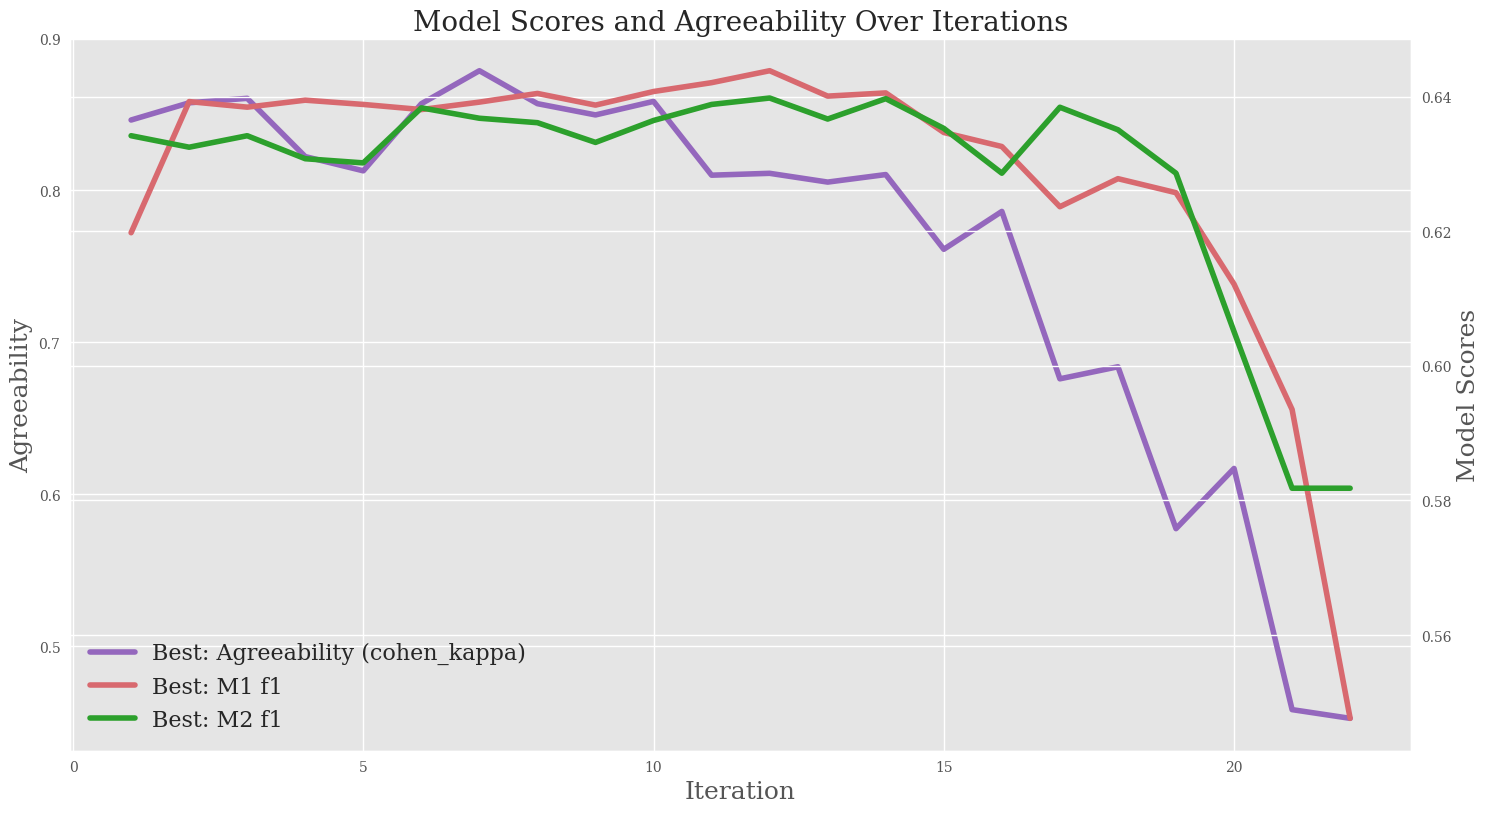

In [30]:
mlp_logit.plot_best()

Make a plot of mean scores:

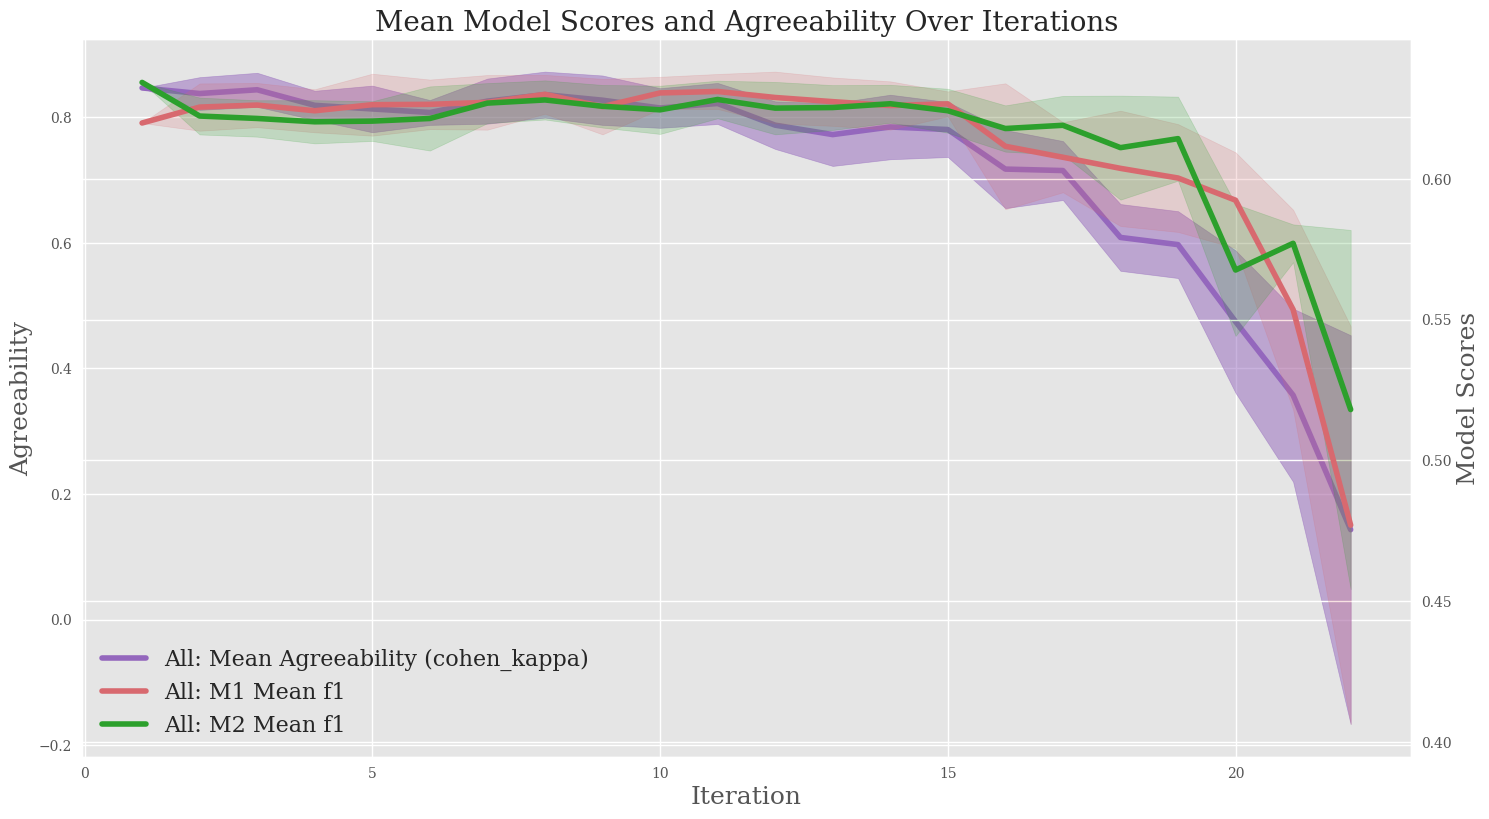

In [29]:
mlp_logit.plot_all()

Compare predictions within models best predictions:

In [32]:
mlp_logit.compare_n_best(n=10, test='mcnemar_chisquare')

Model 1: Results for No.1 and No.2 best preds: P-value: 0.00000000. Test statistic: 115.70568562.
Model 2: Results for No.1 and No.2 best preds: P-value: 0.00000000. Test statistic: 283.08532423.
Model 1: Results for No.2 and No.3 best preds: P-value: 0.00000000. Test statistic: 171.02473498.
Model 2: Results for No.2 and No.3 best preds: P-value: 0.00000000. Test statistic: 277.27457627.
Model 1: Results for No.3 and No.4 best preds: P-value: 0.00000000. Test statistic: 124.21122112.
Model 2: Results for No.3 and No.4 best preds: P-value: 0.00000000. Test statistic: 203.95065789.
Model 1: Results for No.4 and No.5 best preds: P-value: 0.00000000. Test statistic: 234.50328947.
Model 2: Results for No.4 and No.5 best preds: P-value: 0.00000000. Test statistic: 204.72818792.
Model 1: Results for No.5 and No.6 best preds: P-value: 0.00000000. Test statistic: 196.00000000.
Model 2: Results for No.5 and No.6 best preds: P-value: 0.00000000. Test statistic: 274.56333333.
Model 1: Results for

## 5.2) Random Forest and MultiLayer Perceptron

In [33]:
# Initialize a new instance of BackEliminator
rfc_mlp = BackEliminator(
    X=X_train_scaled,
    y=y_train,
    validation_data=(X_val_scaled, y_val),
    task_type='classification',
    criterion='f1',
    agreeability='cohen_kappa',
    dummy_list=dummy_list,
)

In [34]:
# Run the comparison algorithm
results_rfc_mlp = rfc_mlp.compare_models(
    m1=rfc,  # Random Forest
    m2=mlp,  # Neural Net
    keras_params=keras_params,
)

Initial run: fitted both models with full feature set.
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 1 included: ['Latitude', 'Longitude', 'TenureMonths', 'MonthlyCharges', 'TotalCharges', 'CLTV', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', ['MultipleLines_No_phone_service', 'MultipleLines_Yes'], ['InternetService_Fiber_optic', 'InternetService_No'], ['OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes'], ['OnlineBackup_No_internet_service', 'OnlineBackup_Yes'], ['DeviceProtection_No_internet_service', 'DeviceProtection_Yes'], ['TechSupport_No_internet_service', 'TechSupport_Yes'], ['StreamingTV_No_internet_service', 'StreamingTV_Yes'], ['StreamingMovies_No_internet_service', 'StreamingMovies_Yes'], ['Contract_One_year', 'Contract_Two_year'], ['PaymentMethod_Credit_card_(automatic)', 'PaymentMethod_Electronic_check', 'PaymentMe

2024-03-01 19:23:35.376542: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 85.0KiB (rounded to 87040)requested by op sequential_353/dense_0/MatMul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-03-01 19:23:35.378455: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-03-01 19:23:35.378504: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 3804, Chunks in use: 3803. 951.0KiB allocated for chunks. 950.8KiB in use in bin. 18.2KiB client-requested in use in bin.
2024-03-01 19:23:35.378527: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-03-01 19:2

ResourceExhaustedError: Graph execution error:

Detected at node sequential_353/dense_0/MatMul defined at (most recent call last):
  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/tmp/ipykernel_31147/2155906951.py", line 2, in <module>

  File "/home/RDC/anasashb/Dokumente/alice/alice/search_and_compare/sequential.py", line 474, in compare_models

  File "/home/RDC/anasashb/Dokumente/alice/alice/search_and_compare/sequential.py", line 236, in _deselect_feature

  File "/home/RDC/anasashb/Dokumente/alice/alice/utils/model_training.py", line 156, in fit

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/RDC/anasashb/.conda/envs/ansb/lib/python3.9/site-packages/keras/src/layers/core/dense.py", line 241, in call

OOM when allocating tensor with shape[32,680] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_353/dense_0/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_3869311]

In [ ]:
results_rfc_mlp_df = rfc_mlp.dataframe_from_results()

In [ ]:
rfc_mlp.interactive_plot()

In [ ]:
rfc_mlp.plot_best()

In [ ]:
rfc_mlp.plot_all()

In [ ]:
rfc_mlp.compare_n_best(n=10, test='mcnemar_chisquare')

Model 1: Results for No. 1 and No. 2 best predictions: P-value: 0.00000000. Test statistic: 283.08532423.
Model 2: Results for No. 1 and No. 2 best predictions: P-value: 0.00000000. Test statistic: 136.48986486.
Model 1: Results for No. 2 and No. 3 best predictions: P-value: 0.00000000. Test statistic: 277.27457627.
Model 2: Results for No. 2 and No. 3 best predictions: P-value: 0.00000000. Test statistic: 201.04983389.
Model 1: Results for No. 3 and No. 4 best predictions: P-value: 0.00000000. Test statistic: 203.95065789.
Model 2: Results for No. 3 and No. 4 best predictions: P-value: 0.00000000. Test statistic: 217.22558923.
Model 1: Results for No. 4 and No. 5 best predictions: P-value: 0.00000000. Test statistic: 204.72818792.
Model 2: Results for No. 4 and No. 5 best predictions: P-value: 0.00000000. Test statistic: 239.60596026.
Model 1: Results for No. 5 and No. 6 best predictions: P-value: 0.00000000. Test statistic: 274.56333333.
Model 2: Results for No. 5 and No. 6 best pred

## 5.2) Random Forest and Logistic Regression

In [ ]:
# Initialize another Backeliminator
rfc_logit = BackEliminator(
    X=X_train_scaled,
    y=y_train,
    validation_data=(X_val_scaled, y_val),
    task_type='classification',
    criterion='f1',
    agreeability='cohen_kappa',
    dummy_list=dummy_list,
)

In [ ]:
# Run the comparison algorithm
results_rfc_logit = rfc_logit.compare_all_models(
    m1=rfc, # Model 1: Random Forest Classifier
    m2=logit, # Model 2: Logistic Regression
)

Initial run: fitted both models with full feature set.
------------------------------------------------------------------------------------------------------------------------------------------------------
Model 1 included: ['Latitude', 'Longitude', 'TenureMonths', 'MonthlyCharges', 'TotalCharges', 'CLTV', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', ['MultipleLines_No_phone_service', 'MultipleLines_Yes'], ['InternetService_Fiber_optic', 'InternetService_No'], ['OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes'], ['OnlineBackup_No_internet_service', 'OnlineBackup_Yes'], ['DeviceProtection_No_internet_service', 'DeviceProtection_Yes'], ['TechSupport_No_internet_service', 'TechSupport_Yes'], ['StreamingTV_No_internet_service', 'StreamingTV_Yes'], ['StreamingMovies_No_internet_service', 'StreamingMovies_Yes'], ['Contract_One_year', 'Contract_Two_year'], ['PaymentMethod_Credit_card_(automatic)', 'PaymentMethod_Electronic_check', 'PaymentMe

In [ ]:
results_rfc_logit_df = rfc_logit.dataframe_from_results()

In [ ]:
rfc_logit.interactive_plot()

In [ ]:
rfc_logit.plot_best()

In [ ]:
rfc_logit.plot_all()

In [ ]:
rfc_logit.compare_n_best(n=10, test='mcnemar_chisquare')

Model 1: Results for No. 1 and No. 2 best predictions: P-value: 0.00000000. Test statistic: 283.08532423.
Model 2: Results for No. 1 and No. 2 best predictions: P-value: 0.00000000. Test statistic: 199.30795848.
Model 1: Results for No. 2 and No. 3 best predictions: P-value: 0.00000000. Test statistic: 277.27457627.
Model 2: Results for No. 2 and No. 3 best predictions: P-value: 0.00000000. Test statistic: 197.36585366.
Model 1: Results for No. 3 and No. 4 best predictions: P-value: 0.00000000. Test statistic: 203.95065789.
Model 2: Results for No. 3 and No. 4 best predictions: P-value: 0.00000000. Test statistic: 190.19081272.
Model 1: Results for No. 4 and No. 5 best predictions: P-value: 0.00000000. Test statistic: 204.72818792.
Model 2: Results for No. 4 and No. 5 best predictions: P-value: 0.00000000. Test statistic: 150.08928571.
Model 1: Results for No. 5 and No. 6 best predictions: P-value: 0.00000000. Test statistic: 274.56333333.
Model 2: Results for No. 5 and No. 6 best pred

# 6) Small Cross-Comparison of results

For further analysis, if the experiments were ran in one session, we can use `results_mlp_logit_df`, 
`results_rfc_mlp_df` and `results_rfc_logit_df`; or just import the result dictionaries
from their corresponding experiment folders.

In [36]:
# If needs to be imported
import json
RESULTS_MLP_LOGIT_PATH = "test_results/experiment_results_20240301_1/experiment_results_20240301_1.json"
RESULTS_RFC_MLP_PATH = ""
RESULTS_RFC_LOGIT_PATH = ""

# Read the experiment results
with open(RESULTS_MLP_LOGIT_PATH, "r") as f:
    results_mlp_logit = json.load(f)

with open(RESULTS_RFC_MLP_PATH, "r") as f:
    results_rfc_mlp = json.load(f)

with open(RESULTS_RFC_LOGIT_PATH, "r") as f:
    results_rfc_logit = json.load(f)


# Generate dataframes
results_mlp_logit_df = pd.DataFrame(results_mlp_logit)
results_rfc_mlp_df = pd.DataFrame(results_rfc_mlp)
results_rfc_logit_df = pd.DataFrame(results_rfc_logit)

In [ ]:
# Plot confiurations
plt.rcParams["figure.figsize"] = [15, 8]
plt.rcParams.update({"font.family": "serif"})
plt.style.use("ggplot")

We can compare best agreeabilities between the models **across experiments**:

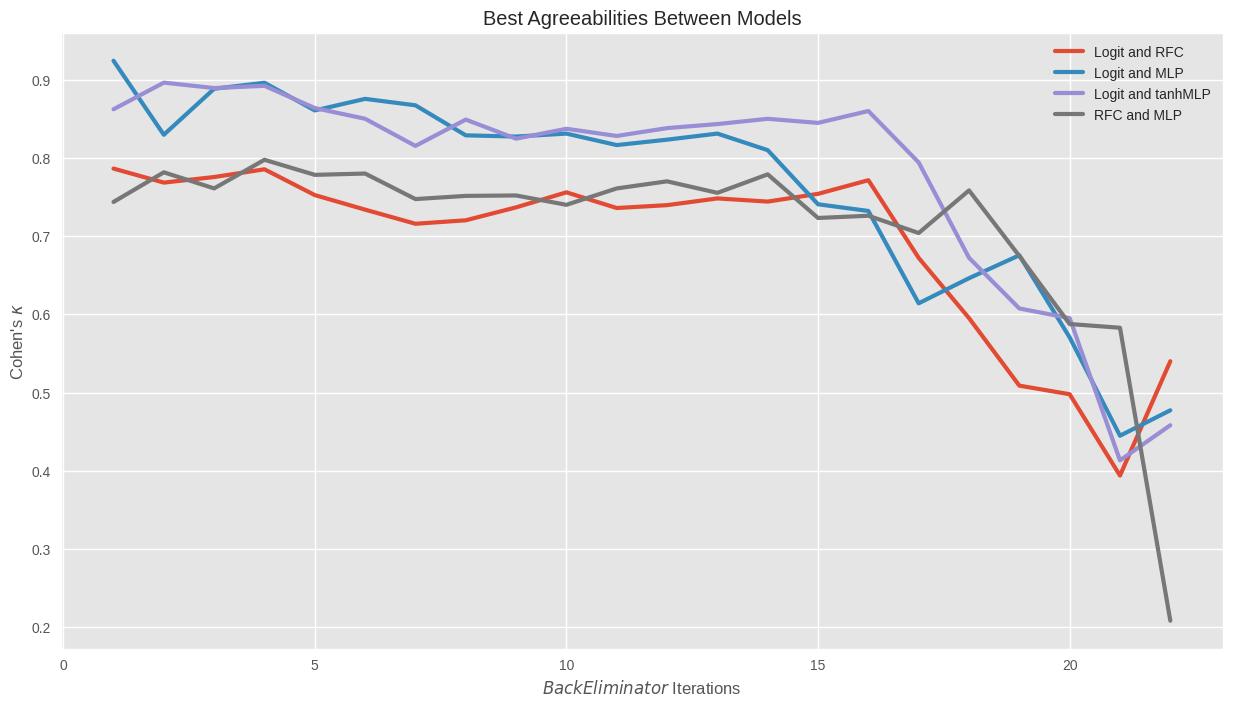

In [187]:
agree_col = "Best: Agreeability (cohen_kappa)"
algorithm_iterations = results_mlp_logit_df.index + 1
plt.plot(
    algorithm_iterations,
    results_mlp_logit_df[agree_col],
    label="Logit and MLP",
    linewidth=3,
)
plt.plot(
    algorithm_iterations,
    results_rfc_mlp_df[agree_col],
    label="RFC and MLP",
    linewidth=3,
)
plt.plot(
    algorithm_iterations,
    results_rfc_logit_df[agree_col],
    label="RFC and Logit",
    linewidth=3,
)
plt.title("Best Agreeabilities Between Models", fontsize=20)
plt.ylabel("Cohen\'s $\kappa$", fontsize=18)
plt.xlabel("$BackEliminator$ Iterations", fontsize=18)
plt.legend(loc="best", fontsize=16)
plt.show()

We can compare mean agreeabilities between the models **across experiments**:

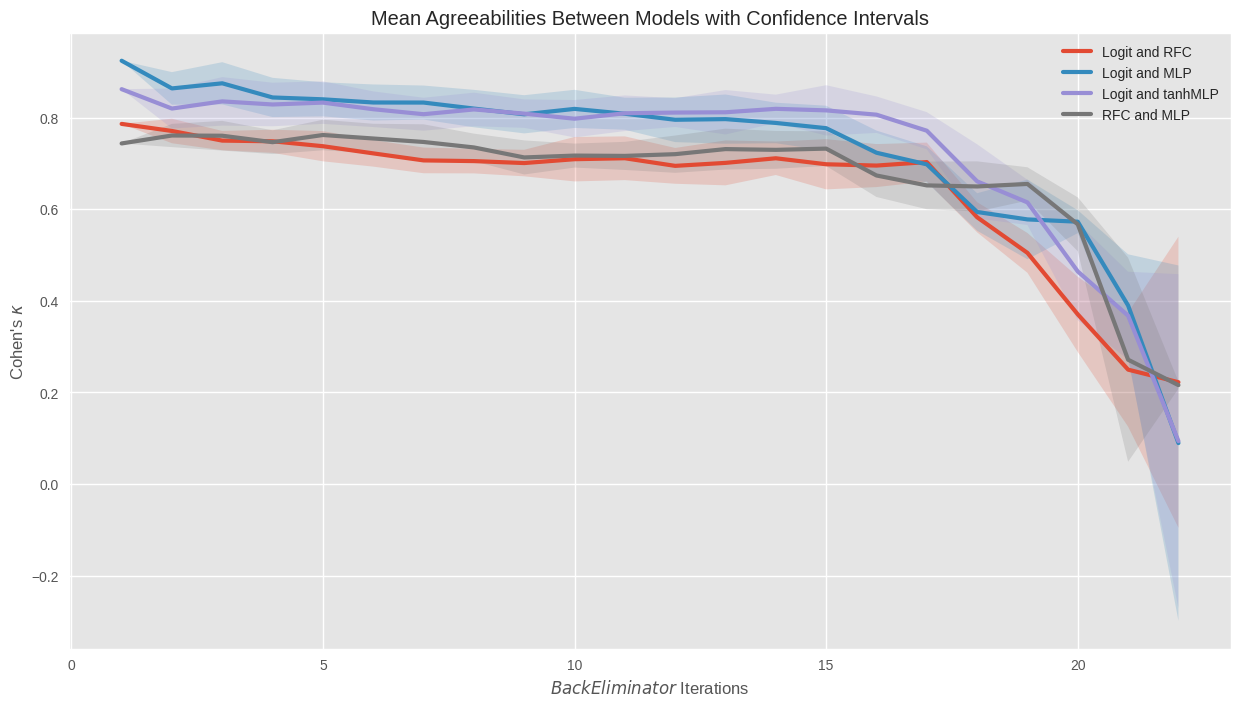

In [188]:
mean_agree_col = "All: Mean Agreeability (cohen_kappa)"
std_agree_col = "All: Agreeability St. Dev."
algorithm_iterations = results_mlp_logit_df.index + 1
plt.plot(
    algorithm_iterations,
    results_mlp_logit_df[mean_agree_col],
    label="Logit and MLP",
    linewidth=3,
)
plt.plot(
    algorithm_iterations,
    results_rfc_mlp_df[mean_agree_col],
    label='RFC and MLP',
    linewidth=3,
)
plt.plot(
    algorithm_iterations,
    results_rfc_logit_df[mean_agree_col],
    label='RFC and Logit',
    linewidth=3,
)

plt.fill_between(
    algorithm_iterations,
    results_mlp_logit_df[mean_agree_col] - results_mlp_logit_df[std_agree_col],
    results_mlp_logit_df[mean_agree_col] + results_mlp_logit_df[std_agree_col],
    alpha=0.2,
)
plt.fill_between(
    algorithm_iterations,
    results_rfc_mlp_df[mean_agree_col] - results_rfc_mlp_df[std_agree_col],
    results_rfc_mlp_df[mean_agree_col] + results_rfc_mlp_df[std_agree_col],
    alpha=0.2,
)
plt.fill_between(
    algorithm_iterations,
    results_rfc_logit_df[mean_agree_col] - results_rfc_logit_df[std_agree_col],
    results_rfc_logit_df[mean_agree_col] + results_rfc_logit_df[std_agree_col],
    alpha=0.2
)

plt.title(
    "Mean Agreeabilities Between Models with Confidence Intervals",
    fontsize=20
)
plt.ylabel("Cohen\'s $\kappa$", fontsize=18)
plt.xlabel("$BackEliminator$ Iterations", fontsize=18)
plt.legend(loc="best", fontsize=16)
plt.show()

### Working Code for 3D Plot

```python

# Create a 3D scatter plot
fig = go.Figure(data=[
    go.Scatter3d(
        x=df.index + 1,
        y=df.iloc[:, 4],
        z=df.iloc[:, 1], 
        mode='lines+markers',
        name=f'{df.columns[1]}',
        text=df['Summary_M1'],
        hoverinfo='text'
    ),
    go.Scatter3d(
        x=df.index + 1,
        y=df.iloc[:, 4],
        z=df.iloc[:, 3], 
        mode='lines+markers',
        name=f'{df.columns[3]}',
        text=df['Summary_M2'],
        hoverinfo='text'
    )
])

# Update layout
fig.update_layout(
    title='Agreeability Coefficients and Model Scores Over Algorithm Iterations',
    scene=dict(
        xaxis_title='Iteration',
        yaxis_title='Agreeability',
        zaxis_title='Model Scores'
    ),
    hovermode='closest'
)

# Show the plot
fig.show()

```

### Dependencies

In [201]:
import numpy as np
import pandas as pd
import statsmodels
import sklearn
import scipy
import plotly
import matplotlib
import seaborn as sns
import tensorflow as tf
import openpyxl
import imblearn
import nbformat

In [202]:
print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'statsmodels: {statsmodels.__version__}')
print(f'sklearn: {sklearn.__version__}')
print(f'scipy: {scipy.__version__}')
print(f'plotly: {plotly.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
print(f'seaborn: {sns.__version__}')
print(f'tensorflow: {tf.__version__}')
print(f'openpyxl: {openpyxl.__version__}')
print(f'imblearn: {imblearn.__version__}')
print(f'nbformat: {nbformat.__version__}')

pandas: 1.5.3
numpy: 1.24.4
statsmodels: 0.13.5
sklearn: 1.1.3
scipy: 1.11.3
plotly: 5.18.0
matplotlib: 3.6.0
seaborn: 0.12.2
tensorflow: 2.14.0
openpyxl: 3.1.2
imblearn: 0.11.0
nbformat: 5.9.2
